In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import time
from sklearn.metrics import classification_report
from PIL import Image

In [2]:
dataset = './dataset/images/'
imageLabels = './dataset/imageLabels.txt'

In [3]:
# Dataset settings
train_vol = 0.8

# Train settings
batch_size = 32
epochs = 15
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

In [4]:
categories = [
    "Pepperoni",
    "Bacon",
    "Mushrooms",
    "Onions",
    "Peppers",
    "Black olives",
    "Tomatoes",
    "Spinach",
    "Fresh basil",
    "Arugula",
    "Broccoli",
    "Corn",
    "Pineapple"
]

In [5]:
with open(imageLabels, 'r') as file:
    lines = file.readlines()
    labels = []
    for line in lines:
        class_array = [int(num) for num in line.split()]
        labels.append(class_array)
     
    y1=labels
    labels= np.array(labels)    
        

print(labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
print(len(labels[0]))

13


In [8]:
image_names = ['{:05d}'.format(i) for i in range(1,9214)]

In [9]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)  # Adjust channels as needed
    img = tf.image.resize(img, [244, 244])  # Set desired image dimensions
    img = img / 255.0  # Normalize pixel values
    return img

In [10]:
image_paths = [os.path.join(dataset, img+'.jpg') for img in image_names]
image_paths[0:10]

['./dataset/images/00001.jpg',
 './dataset/images/00002.jpg',
 './dataset/images/00003.jpg',
 './dataset/images/00004.jpg',
 './dataset/images/00005.jpg',
 './dataset/images/00006.jpg',
 './dataset/images/00007.jpg',
 './dataset/images/00008.jpg',
 './dataset/images/00009.jpg',
 './dataset/images/00010.jpg']

In [11]:
def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [18]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
# Parse and preprocess observations in parallel
dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

In [22]:
len(dataset)

9213

In [28]:
dataset = dataset.shuffle(buffer_size=9213)
        
# Split into train/validate
train_size = int(train_vol * len(dataset))

test_dataset = dataset.skip(train_size)
train_dataset = dataset.take(train_size)

train_dataset = dataset.batch(batch_size)
test_dataset = dataset.batch(batch_size)

In [23]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 53, 53, 32)       

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
"""
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)
"""
# Train model
run_hist = model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size)

Epoch 1/15


288/288 [==============================] - 154s 513ms/step - loss: 0.3175 - accuracy: 0.2506 - val_loss: 0.2558 - val_accuracy: 0.1058
Epoch 2/15
288/288 [==============================] - 145s 495ms/step - loss: 0.2680 - accuracy: 0.3487 - val_loss: 0.2493 - val_accuracy: 0.3339
Epoch 3/15
288/288 [==============================] - 146s 498ms/step - loss: 0.2583 - accuracy: 0.3863 - val_loss: 0.2455 - val_accuracy: 0.4218
Epoch 4/15
288/288 [==============================] - 146s 496ms/step - loss: 0.2526 - accuracy: 0.4081 - val_loss: 0.2471 - val_accuracy: 0.4475
Epoch 5/15
288/288 [==============================] - 145s 493ms/step - loss: 0.2472 - accuracy: 0.4049 - val_loss: 0.2393 - val_accuracy: 0.4052
Epoch 6/15
288/288 [==============================] - 152s 516ms/step - loss: 0.2429 - accuracy: 0.4066 - val_loss: 0.2371 - val_accuracy: 0.3376
Epoch 7/15
288/288 [==============================] - 148s 502ms/step - loss: 0.2395 - accuracy: 0.4063 - val_loss: 0.2312

In [35]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), accuracy, label='Training accuracy')
    plt.plot(range(1, epochs+1), val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, accuracy, val_accuracy

In [31]:
import matplotlib.style as style 

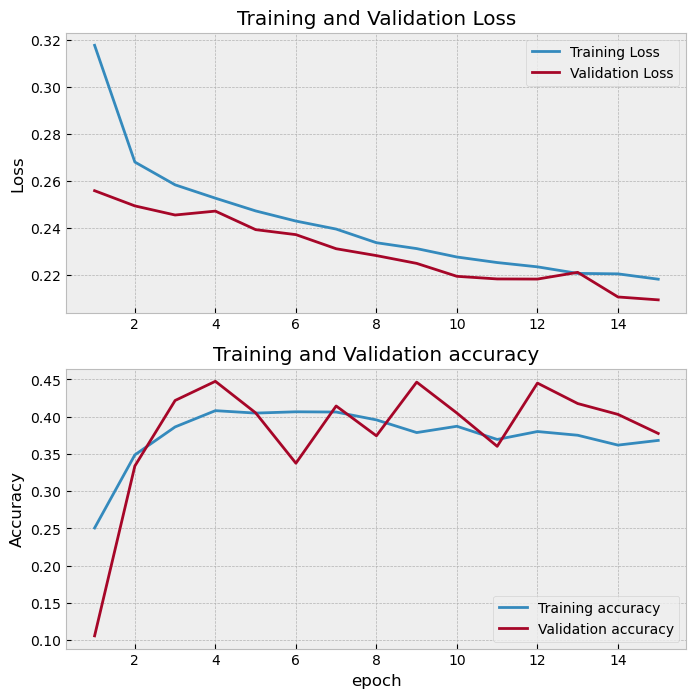

In [36]:
loss, val_loss, accuracy, val_accuracy = learning_curves(run_hist)


In [66]:
import numpy as np

def Average_Precision(pred_tags, gt_tags):
    if len(pred_tags) == 0 or len(gt_tags) == 0:
        return 0

    # Convert to numpy arrays
    pred_tags = np.asarray(pred_tags)
    gt_tags = np.asarray(gt_tags)

    # Sort predictions by confidence (assuming higher confidence = positive prediction)
    sorted_indices = np.argsort(pred_tags)[::-1]
    pred_tags_sorted = pred_tags[sorted_indices]
    gt_tags_sorted = gt_tags[sorted_indices]

    # Calculate true positives (TP) and false positives (FP) at each threshold
    TP = np.cumsum(gt_tags_sorted)
    FP = np.cumsum(1 - gt_tags_sorted)
    
    # Calculate precision and recall at each threshold
    if np.sum(gt_tags) == 0:  # Handle the case of all ground truth tags being zeros
        precision = np.zeros_like(TP)
        recall = np.zeros_like(TP)
    else:
        precision = TP / (TP + FP)
        recall = TP / np.sum(gt_tags)

    # Compute Average Precision (AP) using the area under the precision-recall curve
    # (with linear interpolation)
    ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])

    return ap

def mAP(pred_tags_list, gt_tags_list):
    # Calculate AP for each sample
    ap_list = [Average_Precision(pred_tags, gt_tags) for pred_tags, gt_tags in zip(pred_tags_list, gt_tags_list)]

    # Compute mean AP
    mean_ap = np.mean(ap_list)

    return mean_ap


In [43]:
# Example usage
gt_tags = [1, 0, 1, 0, 1, 1, 0, 1]  # Ground truth tags (presence or absence of topping)
pred_tags = [1, 1, 1, 0, 0, 1, 0, 1]  # Predicted tags


gt_tags_binary,pred_tags_binary


([1, 0, 1, 0, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1, 0, 1])

In [45]:
# Calculate mAP
m_ap = mAP([pred_tags], [gt_tags])
print("mAP:", m_ap)

mAP: 0.7028571428571428


In [57]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.int32, name=None))>

In [58]:
(model.predict(x_batch) > 0.5).astype(int)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.int32, name=None))>

In [69]:
for x_batch, y_batch in test_dataset:
    print((model.predict(x_batch) > 0.5).astype(int), y_batch.numpy())
    m_ap = mAP((model.predict(x_batch) > 0.5).astype(int),  y_batch.numpy())
    print("mAP:", m_ap)
    break


1/1 [==============================] - 0s 179ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]] [[0 0 1 1 1 1 0 0 

In [71]:
# List to store all predicted tags
pred_tags_list = []
gt_tags_list = []


# Iterate over the test dataset to obtain predictions
for x_batch, y_batch in test_dataset:
    yp=(model.predict(x_batch) > 0.5).astype(int)
    yt= y_batch.numpy()
    # Append predicted tags to the list
    pred_tags_list.append(yp.tolist())
    gt_tags_list.append(yt.tolist())

print(pred_tags_list)
print(y_test_list)
m_ap = mAP(pred_tags_list, gt_tags_list)
print("mAP:", m_ap)


1/1 [==============================] - 0s 191ms/step
[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0

In [53]:
print(pred_tags_list[0])
print(len(y_test_list))


[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]
9213
